# **DATA SCIENCE ITINERARY - IT ACADEMY**

# **Sprint 12. Advanced Machine Learning**

# WEB SCRAPPING

In [263]:
# Libraries and modules

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns

# Beatiful Soup and Selenium libraries and modules
import requests
from bs4 import BeautifulSoup
import selenium
from selenium import webdriver 
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
import re
from PIL import Image
import time

# Word Document libraries and modules
from docx import Document
from docx.shared import Inches
from docx.enum.text import WD_LINE_SPACING
from docx import text
from docx.shared import Pt
from scrapy import Selector

# Web Scrapping libraries and modules
import scrapy
from scrapy import signals
from scrapy.exporters import CsvItemExporter
from scrapy.http import TextResponse
from scrapy import Selector
from scrapy.pipelines.images import ImagesPipeline
from scrapy.exceptions import DropItem
from scrapy import Request
from scrapy.spiders import CrawlSpider, Rule, Spider
from scrapy.linkextractors import LinkExtractor
from scrapy.exceptions import CloseSpider
from scrapy.crawler import CrawlerRunner, CrawlerProcess
from fake_useragent import UserAgent
import scrapy_fake_useragent
from scrapy.http import TextResponse
import csv



## **EXERCISE 1**

**STATEMENT:** **Scraping** a page on the Madrid Stock Exchange (https://www.bolsamadrid.es) using BeautifulSoup and Selenium.

In [264]:
# The url page

url = 'https://www.bolsamadrid.es/'
html_page = requests.get(url)


### **BEAUTIFUL SOUP**

THIS LIBRARY ALLOWS US TO SCRAP A WEB PAGE ALLOWING US TO CHOOSE THE INFORMATION WE WANT. 

**'HTML.PARSER'** ENSURE THAT THE RIGHT PARSER IS USED FOR THE HTML CONTENT.

WE WANT TO SCRAP THE TABLE OF THE SHARES OF THE MADRID STOCK EXCHANGE

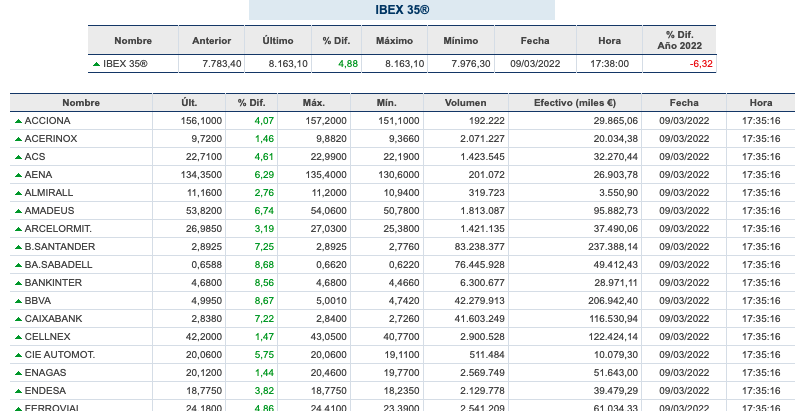

In [302]:
Image.open('share_table.png')

#### **METHOD 1**

In [266]:
beatiful_soup = BeautifulSoup(html_page.content, 'html.parser')

OUR GOAL IS TO EXTRACT DATA FROM A WEB PAGE. THEREFORE, WE WILL FOCUS ON EXTRACTING THE DATA OF THE SHARES OF THE IBEX 35 FROM THE MADRID STOCK EXCHANGE.

**STEP 1:** FIND THE WEB PAGE WHERE THE ACTIONS ARE FOUND AND SAVE IT IN A LIST.

In [267]:
shares_link = []

for share_link in beatiful_soup.find_all('a', string = 'Acciones'):
    shares_link.append(share_link.get('href'))

shares_link[0] # We have the link of the shares

'/esp/aspx/Mercados/Precios.aspx?indice=ESI100000000'

**STEP 2:** ONCE WE HAVE THE SHARES PAGE, WE WANT TO GET THE IBEX 35 SHARES TABLE BY CREATING A DATAFRAME. FIRST WE WILL TAKE THE NAMES OF THE COLUMNS AND SAVE THEM IN A LIST.

In [268]:
# Now we have a new url
shares_url = url + shares_link[0]
print('The new address to access the shares table is: ', '\n', shares_url)
html_shares = requests.get(shares_url)
beatiful_soup_shares = BeautifulSoup(html_shares.content, 'html.parser')

The new address to access the shares table is:  
 https://www.bolsamadrid.es//esp/aspx/Mercados/Precios.aspx?indice=ESI100000000


In [269]:
# The columns 

shares = beatiful_soup_shares.find(id = 'ctl00_Contenido_tblAcciones')
columns= shares.find_all('th')

share_columns = []

for column in columns:
    share_columns.append(column.get_text())

share_columns

['Nombre',
 'Últ.',
 '% Dif.',
 'Máx.',
 'Mín.',
 'Volumen',
 'Efectivo (miles €)',
 'Fecha',
 'Hora']

**STEP 3:** ONCE WE HAVE THE COLUMNS WE WANT TO EXTRACT THE RECORDS THAT WILL COMPLETE THE SHARE TABLE.

In [270]:
# The records

records = shares.find_all('td')

share_records = []

for record in records:
    share_records.append(record.text)

share_records[:9] # We show only the first share of the table

['ACCIONA',
 '156,1000',
 '4,07',
 '157,2000',
 '151,1000',
 '192.222',
 '29.865,06',
 '09/03/2022',
 '17:35:16']

**STEP 4:** WE CREATE A DATAFRAME WITH THE DATA WE HAVE EXTRACTED FROM THE WEBSITE OF THE MADRID STOCK EXCHANGE.

In [271]:
shares_data = {}

for i in range(9):
    shares_data[share_columns[i]] = share_records[i::9] # I skip every 9 items to have the same types of values

shares_data = pd.DataFrame(shares_data)
shares_data.head()

,Nombre,Últ.,% Dif.,Máx.,Mín.,Volumen,Efectivo (miles €),Fecha,Hora
0,ACCIONA,"156,1000","4,07","157,2000","151,1000",192.222,"29.865,06",09/03/2022,17:35:16
1,ACERINOX,"9,7200","1,46","9,8820","9,3660",2.071.227,"20.034,38",09/03/2022,17:35:16
2,ACS,"22,7100","4,61","22,9900","22,1900",1.423.545,"32.270,44",09/03/2022,17:35:16
3,AENA,"134,3500","6,29","135,4000","130,6000",201.072,"26.903,78",09/03/2022,17:35:16
4,ALMIRALL,"11,1600","2,76","11,2000","10,9400",319.723,"3.550,90",09/03/2022,17:35:16


In [272]:
# Save the data to csv
shares_data.to_csv('shares_table.csv')

#### **METHOD 2**

WE CREATE A FUNCTION THAT SCRAPES THE WEB PAGE THAT WE INTRODUCE

In [273]:
shares_url # Link shares page

def scraping_the_page(url_page):
    
    try:
        html = requests.get(url_page)

    except HTTPError as error:
        print(error)

    except URLError:
        print('Server down or incorrect domain')

    else:
        beatiful_soup = BeautifulSoup(html.content, 'html.parser')

        return beatiful_soup

In [274]:
beautiful_soup2 = scraping_the_page(shares_url)

In [275]:
# Share Table Function

def share_table(url_content):
    rows = []

    for child in beautiful_soup2.find_all('table')[4].children: # The important information is in the 4th table
        element = []

        for td in child:
            try:
                 element.append(td.text.replace('\n', ''))
            except:
                continue

        if len(element)> 0:
            rows.append(element)

    # Dataframe
    shares_df = pd.DataFrame(rows[1:], columns = rows[0])

    return shares_df

In [276]:
share_table(beautiful_soup2).head()

,Nombre,Últ.,% Dif.,Máx.,Mín.,Volumen,Efectivo (miles €),Fecha,Hora
0,ACCIONA,"156,1000","4,07","157,2000","151,1000",192.222,"29.865,06",09/03/2022,17:35:16
1,ACERINOX,"9,7200","1,46","9,8820","9,3660",2.071.227,"20.034,38",09/03/2022,17:35:16
2,ACS,"22,7100","4,61","22,9900","22,1900",1.423.545,"32.270,44",09/03/2022,17:35:16
3,AENA,"134,3500","6,29","135,4000","130,6000",201.072,"26.903,78",09/03/2022,17:35:16
4,ALMIRALL,"11,1600","2,76","11,2000","10,9400",319.723,"3.550,90",09/03/2022,17:35:16


### **SELENIUM**

SELENIUM IS A TOOL DESIGNED TO HELP YOU RUN AUTOMATED TESTS ON WEB APPLICATIONS.

In [277]:
# We call the Driver and the page we want to scrape
path = './chromedriver'
driver = webdriver.Chrome(path)

driver.get('https://www.bolsamadrid.es')

<ipython-input-277-231933a6bc72>:3: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(path)


WE EXTRACT DATA FROM THE DAILY AGENDA

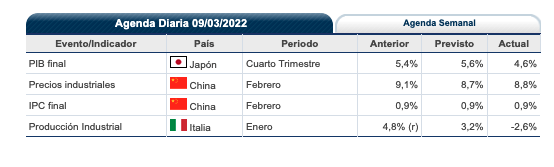

In [278]:
Image.open('agenda_diaria.png')

**INSPIRATION LINK:** https://www.youtube.com/watch?v=0QHvgAcGhUc

In [279]:
# The number of columns in the table
columns_len = len(driver.find_elements_by_xpath('/html/body/div[1]/table/tbody/tr[4]/td[2]/div[1]/table[2]/tbody/tr[3]/td'))

# The number of rows in the table
rows_len = len(driver.find_elements_by_xpath('/html/body/div[1]/table/tbody/tr[4]/td[2]/div[1]/table[2]/tbody/tr'))

# Columns names
columns_names = [ element.text for element in driver.find_elements_by_xpath('/html/body/div[1]/table/tbody/tr[4]/td[2]/div[1]/table[2]/tbody/tr[1]/th')]

# Values
table = []

for i in range(3, rows_len+1):
    row = []
    for j in range(1, columns_len+1):
        tr_td = driver.find_elements_by_xpath('/html/body/div[1]/table/tbody/tr[4]/td[2]/div[1]/table[2]/tbody/tr['+str(i)+']/td['+str(j)+']')
        adding = [element.text for element in tr_td]
        row.append(adding[0])

    table.append(row)

# DataFrame

diary_agenda = pd.DataFrame(table, columns = columns_names)

<ipython-input-279-07c23ff1c7f8>:2: DeprecationWarning: find_elements_by_xpath is deprecated. Please use find_elements(by=By.XPATH, value=xpath) instead
  columns_len = len(driver.find_elements_by_xpath('/html/body/div[1]/table/tbody/tr[4]/td[2]/div[1]/table[2]/tbody/tr[3]/td'))
<ipython-input-279-07c23ff1c7f8>:5: DeprecationWarning: find_elements_by_xpath is deprecated. Please use find_elements(by=By.XPATH, value=xpath) instead
  rows_len = len(driver.find_elements_by_xpath('/html/body/div[1]/table/tbody/tr[4]/td[2]/div[1]/table[2]/tbody/tr'))
<ipython-input-279-07c23ff1c7f8>:8: DeprecationWarning: find_elements_by_xpath is deprecated. Please use find_elements(by=By.XPATH, value=xpath) instead
  columns_names = [ element.text for element in driver.find_elements_by_xpath('/html/body/div[1]/table/tbody/tr[4]/td[2]/div[1]/table[2]/tbody/tr[1]/th')]
<ipython-input-279-07c23ff1c7f8>:16: DeprecationWarning: find_elements_by_xpath is deprecated. Please use find_elements(by=By.XPATH, value=xp

In [280]:
# Show the table
print('The daily agenda of the Madrid Stock Exchange: ')
diary_agenda

The daily agenda of the Madrid Stock Exchange: 


,Evento/Indicador,País,Periodo,Anterior,Previsto,Actual
0,Precios industriales,China,Febrero,"9,1%","8,7%","8,8%"
1,IPC final,China,Febrero,"0,9%","0,9%","0,9%"
2,Producción Industrial,Italia,Enero,"4,8% (r)","3,2%","-2,6%"


In [281]:
# We import the date 

date = driver.find_element_by_xpath('/html/body/div[1]/table/tbody/tr[4]/td[2]/div[1]/table[1]/tbody/tr/td[1]/div/div/div/a')
date = re.findall('\d*/\d*/\d*', date.text)[0]

<ipython-input-281-41deeb13b7c7>:3: DeprecationWarning: find_element_by_xpath is deprecated. Please use find_element(by=By.XPATH, value=xpath) instead
  date = driver.find_element_by_xpath('/html/body/div[1]/table/tbody/tr[4]/td[2]/div[1]/table[1]/tbody/tr/td[1]/div/div/div/a')


In [282]:
# Adding 'date' on the table

diary_agenda['Fecha'] = date
reordering_columns = diary_agenda.columns.tolist()
reordering_columns = reordering_columns[-1:] + reordering_columns[:-1]
diary_agenda = diary_agenda[reordering_columns]
diary_agenda

,Fecha,Evento/Indicador,País,Periodo,Anterior,Previsto,Actual
0,09/03/2022,Precios industriales,China,Febrero,"9,1%","8,7%","8,8%"
1,09/03/2022,IPC final,China,Febrero,"0,9%","0,9%","0,9%"
2,09/03/2022,Producción Industrial,Italia,Enero,"4,8% (r)","3,2%","-2,6%"


In [283]:
# Close the driver
driver.close()

In [284]:
diary_agenda.to_csv('diary_agenda.csv')

## **EXERCISE 2**

**STATEMENT:** Document in a **Word** your data set generated with the information that the different Kaggle files have.

**LINK:** https://python-docx.readthedocs.io/

In [285]:
shares_data.head(2)

,Nombre,Últ.,% Dif.,Máx.,Mín.,Volumen,Efectivo (miles €),Fecha,Hora
0,ACCIONA,"156,1000","4,07","157,2000","151,1000",192.222,"29.865,06",09/03/2022,17:35:16
1,ACERINOX,"9,7200","1,46","9,8820","9,3660",2.071.227,"20.034,38",09/03/2022,17:35:16


In [286]:
document = Document()

# Heading
document.add_heading('IBEX 35 Shares', 0)

# Context
document.add_heading(' CONTEXT: ', level = 2)
document.add_paragraph('This document shows the shares listed on the Spanish market. The IBEX 35 is the main reference stock market index of the Spanish stock market prepared by Bolsas y Mercados Españoles.', style = 'List Bullet').runs[0].font.size =Pt(10)


# Content
document.add_heading(' CONTENT: ', level = 2)
document.add_paragraph('Nombre: Share\'s name', style = 'List Bullet').runs[0].font.size = Pt(10)
document.add_paragraph('Últ: Latest share price update', style = 'List Bullet').runs[0].font.size = Pt(10)
document.add_paragraph('% Dif: Share price difference', style = 'List Bullet').runs[0].font.size = Pt(10)
document.add_paragraph('Máx: The maximum share price of the session', style = 'List Bullet').runs[0].font.size = Pt(10)
document.add_paragraph('Mín: The minimum share price of the session', style = 'List Bullet').runs[0].font.size = Pt(10)
document.add_paragraph('Volumen: Share volume', style = 'List Bullet').runs[0].font.size = Pt(10)
document.add_paragraph('Efectivo (miles €):  Company cash', style = 'List Bullet').runs[0].font.size = Pt(10)
document.add_paragraph('Fecha: Daily date', style = 'List Bullet').runs[0].font.size = Pt(10)
document.add_paragraph('Hora: Hour ', style = 'List Bullet').runs[0].font.size = Pt(10)


# Table 
table = document.add_table(rows = 1, cols = len(shares_data.columns), style = 'TableGrid')
hdr_cells = table.rows[0].cells

for i in range(len(shares_data.columns)):
    hdr_cells[i].text = columns[i]
for i in range(len(shares_data)):
    rows_cells = table.add_row().cells
    for j in range(len(shares_data.columns)):
        rows_cells[j].text = str(shares_data.iat[i,j])

paragraph = document.add_paragraph()
paragraph.paragraph_format.line_spacing_rule = WD_LINE_SPACING.EXACTLY

document.add_page_break()

document.save('IBEX35_shares.docx')

/Users/adrianova/opt/anaconda3/lib/python3.8/site-packages/docx/styles/styles.py:139: UserWarning: style lookup by style_id is deprecated. Use style name as key instead.
  return self._get_style_id_from_style(self[style_name], style_type)


THE DOCUMENT IS INSIDE THE GITHUB FOLDER:
 https://github.com/adrianova8/Web_Scraping.git



## **EXERCISE 3**

**STATEMENT:** Choose a web page you want and do web scraping using the Scrapy library.

**LINK:** https://www.youtube.com/watch?v=ve_0h4Y8nuI

In [287]:
# Web Page 'URL'
url = 'https://www.myprotein.es/clothing/mens/sweatshirts-and-hoodies.list'
print(url)

https://www.myprotein.es/clothing/mens/sweatshirts-and-hoodies.list


In [288]:
# User Agent (like an identificator)
headers = {'user-agent': UserAgent().Chrome}
print(headers)

{'user-agent': 'Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/27.0.1453.90 Safari/537.36'}


A USER AGENT IS A COMPUTER PROGRAM REPRESENTING A PERSON, FOR EXAMPLE, A BROWSER IN A WEB CONTEXT. BESIDES A BROWSER, A USER AGENT COULD BE A BOT SCRAPING WEBPAGES, A DOWNLOAD MANAGER, OR ANOTHER APP ACCESSING THE WEB.

In [289]:
# Status Code
status_code = requests.get(url, headers = headers)
print(status_code)

<Response [200]>


AN HTTP STATUS CODE 200 MEANS SUCCESS. THE CLIENT HAS REQUESTED DOCUMENTS FROM THE SERVER. THE SERVER HAS REPLIED TO THE CLIENT AND GIVEN THE CLIENT THE DOCUMENTS.

In [290]:
# Text Response
response = TextResponse(status_code.url, body = status_code.text, encoding = 'utf-8')
print(response)

<200 https://www.myprotein.es/clothing/mens/sweatshirts-and-hoodies.list>


THEXT RESPONSE WE CAN ACCESS TO THE STRUCTURE PIECE WHERE WE CAN EXPLORE THE TEXT.

MY PROTEIN IS A CLOTHING AND SPORTS SUPPLEMENTS STORE. OUR PAGE IS FOCUSED ON SWEATSHIRTS WITH AND WITHOUT HOOD. WE WANT TO OBTAIN:

+ THE PARTICULAR LINKS OF EACH ITEM
+ THE NAMES OF EACH ITEM
+ THE PRICES OF EACH ITEM
+ THE IMAGE OF EACH ITEM

In [291]:
# Link of each item
links = response.xpath('//*[@class="productListProducts_products"]/li/div/div/a/@href').extract()
links[:5]

['/sports-sweatshirt/sudadera-con-capucha-negro/12302849.html',
 '/sports-t-shirts/sudadera-con-capucha-gris-pardo/12302856.html',
 '/sports-clothing/sudadera-con-capucha-y-cremallera-tempo-para-hombre-negro/13111224.html',
 '/sports-clothing/sudadera-para-hombre-de-mp-rosa-lavado/13114687.html',
 '/sports-tops/sudadera-con-capucha-oversize-rest-day-para-hombre-de-mp-verde-militar/12762417.html']

In [292]:
# Title of each item
titles = response.xpath('//*[@class="productListProducts_products"]/li/div/a/div/h3/text()').extract()
titles[:4]

['\n                        Sudadera con Capucha - Negro\n                      ',
 '\n                        Sudadera con Capucha - Gris Pardo\n                      ',
 '\n                        Sudadera con capucha y cremallera Tempo para hombre - Negro\n                      ',
 '\n                        Sudadera para hombre de MP - Rosa lavado\n                      ']

In [293]:
# Price of each item
prices = response.xpath('//*[@class="productListProducts_products"]/li/div/div[3]/div/span[2]/text()').extract()
prices[:5]

['35,99 €', '35,99 €', '49,99 €', '31,99 €', '53,99 €']

In [294]:
# Image of each item
images = response.xpath('//*[@class="productListProducts_products"]/li/div/div/a/img/@src').extract()
images[:5]

['https://static.thcdn.com/images/xsmall/original//productimg/original/12302849-7864853131092390.jpg',
 'https://static.thcdn.com/images/xsmall/original//productimg/original/12302856-1064859047923666.jpg',
 'https://static.thcdn.com/images/xsmall/original//productimg/original/13111224-1874909884216048.jpg',
 'https://static.thcdn.com/images/xsmall/original//productimg/original/13114687-1524920560052738.jpg',
 'https://static.thcdn.com/images/xsmall/original//productimg/original/12762417-1484929391261176.jpg']

WE CREATE A PROJECT IN OUR WORK DIRECTORY. AS WE CREATE FILES, THESE WILL BE SAVED IN OUR PROJECT FOLDER.

In [295]:
# MyProtein Project
!scrapy startproject myprotein2

Error: scrapy.cfg already exists in /Users/adrianova/Desktop/Data Science/Python/IT Academy - Python/SPRINT 13 - Machine Learning Avançat/S13 T02_ Web Scraping/myprotein2


WE WRITE IN A FILE WHERE WE WILL SAVE THE ITEMS WE WANT FROM THE WEB PAGE WE ARE SCRAPPING.

In [296]:
%%writefile  myprotein2/myprotein2/items.py
import scrapy

class MyproteinItems(scrapy.Item):
    title = scrapy.Field()
    price = scrapy.Field()
    img = scrapy.Field()
    #link = scrapy.Field()
'''
    def to_dict(self):
        my_protein_data = {'title': self['title'],
        'price': self['price'],
        'img': self['img'],
        'link': self['link']}

        return my_protein_data
'''

Overwriting myprotein2/myprotein2/items.py


In [297]:
# We can show the 'ITEMS.PY' FILE
!cat myprotein2/myprotein2/items.py

import scrapy

class MyproteinItems(scrapy.Item):
    title = scrapy.Field()
    price = scrapy.Field()
    img = scrapy.Field()
    #link = scrapy.Field()
'''
    def to_dict(self):
        my_protein_data = {'title': self['title'],
        'price': self['price'],
        'img': self['img'],
        'link': self['link']}

        return my_protein_data
'''


NOW WE ARE GOING TO WRITE INSIDE THE SPIDER FOLDER, BUT TO DO THIS WE MUST CREATE A **.PY FILE** CALLED **MYPROTEIN_SPIDER.PY**

In [298]:
%%writefile myprotein2/myprotein2/spiders/myprotein_spider.py

import scrapy
from ..items import MyproteinItems
#import scrapy_fake_useragent

class MyproteinSpider(scrapy.Spider):
    name = 'myprotein_products'
    '''
    custom_settings = {
        'DOWNLOADER_MIDDLEWARES' : {
            'scrapy.downloadermiddlewares.useragent.UserAgentMiddleware' : None,
            'scrapy_fake_useragent.middleware.RandomUserAgentMiddleware' : 300,
        }
    }
    '''
    start_urls = ['https://www.myprotein.es/clothing/mens/sweatshirts-and-hoodies.list']
    

    def parse(self, response):
        items = MyproteinItems()

        hoodies = response.css('.athenaProductBlock')

        for hoodie in hoodies:
            title = hoodie.css('.athenaProductBlock_title h3::text').extract()
            price = hoodie.css('.athenaProductBlock_priceValue::text').extract()
            img = hoodie.css('.athenaProductBlock_image_rollover::attr(src)').extract()


            # Save the data
            items['title'] = title
            items['img'] = img
            items['price'] = price


            yield items
        

    '''
    def __init__(self, **kwargs):
        self.start_url = 'https://www.myprotein.es/clothing/mens/sweatshirts-and-hoodies.list'
        super().__init__(**kwargs)
    
    def requests(self):
        import requests
        from fake_useragent import UserAgent
        from scrapy.http import TextResponse

        # Iterate all pages
        headers = {'user-agent': UserAgent().Chrome}
        status_code = requests.get(self.start_urls, headers = headers)
        response = TextResponse(status_code.url, body = status_code.text, encoding = 'utf-8')
        urls = response.xpath('//*[@class="productListPorducts_products"]/li/div/div/a/@href').extract()
        for url in urls:
            yield scrapy.Request(url, callback=self.parse)


    def parse(self, response):

        item = MyproteinItems()
        
        item['title'] = response.xpath('//*[@class="productName_title"]/text()').extract()
        item['price'] = response.xpath('//*[@class="productPrice_price"]/text()').extract()
        item['img'] = response.xpath('//*[@class="athenaProductImageCarousel_image"]/@src').extract()
        item['link'] = response.url

        yield item
        '''

    

Overwriting myprotein2/myprotein2/spiders/myprotein_spider.py


In [299]:
!cat myprotein2/myprotein2/spiders/myprotein_spider.py


import scrapy
from ..items import MyproteinItems
#import scrapy_fake_useragent

class MyproteinSpider(scrapy.Spider):
    name = 'myprotein_products'
    '''
    custom_settings = {
        'DOWNLOADER_MIDDLEWARES' : {
            'scrapy.downloadermiddlewares.useragent.UserAgentMiddleware' : None,
            'scrapy_fake_useragent.middleware.RandomUserAgentMiddleware' : 300,
        }
    }
    '''
    start_urls = ['https://www.myprotein.es/clothing/mens/sweatshirts-and-hoodies.list']
    

    def parse(self, response):
        items = MyproteinItems()

        hoodies = response.css('.athenaProductBlock')

        for hoodie in hoodies:
            title = hoodie.css('.athenaProductBlock_title h3::text').extract()
            price = hoodie.css('.athenaProductBlock_priceValue::text').extract()
            img = hoodie.css('.athenaProductBlock_image_rollover::attr(src)').extract()


            # Save the data
            items['title'] = title
            items['img'] = img
     

In [300]:
!cd myprotein2 && scrapy crawl myprotein_products -o myprotein_products.csv

2022-03-09 17:58:24 [scrapy.utils.log] INFO: Scrapy 2.6.1 started (bot: myprotein2)
2022-03-09 17:58:24 [scrapy.utils.log] INFO: Versions: lxml 4.6.3.0, libxml2 2.9.10, cssselect 1.1.0, parsel 1.6.0, w3lib 1.22.0, Twisted 22.2.0, Python 3.8.8 (default, Apr 13 2021, 12:59:45) - [Clang 10.0.0 ], pyOpenSSL 20.0.1 (OpenSSL 1.1.1k  25 Mar 2021), cryptography 3.4.7, Platform macOS-10.16-x86_64-i386-64bit
2022-03-09 17:58:24 [scrapy.crawler] INFO: Overridden settings:
{'BOT_NAME': 'myprotein2',
 'NEWSPIDER_MODULE': 'myprotein2.spiders',
 'ROBOTSTXT_OBEY': True,
 'SPIDER_MODULES': ['myprotein2.spiders']}
2022-03-09 17:58:24 [scrapy.utils.log] DEBUG: Using reactor: twisted.internet.selectreactor.SelectReactor
2022-03-09 17:58:24 [scrapy.extensions.telnet] INFO: Telnet Password: 2e45ab4b66713fe2
2022-03-09 17:58:24 [scrapy.middleware] INFO: Enabled extensions:
['scrapy.extensions.corestats.CoreStats',
 'scrapy.extensions.telnet.TelnetConsole',
 'scrapy.extensions.memusage.MemoryUsage',
 'scrapy.

In [301]:
# We show the dataframe

myprotein_hoodies = pd.read_csv('./myprotein2/myprotein_products.csv')
myprotein_hoodies.head()

,img,price,title
0,https://static.thcdn.com/images/xsmall/origina...,"35,99 €",\n Sudadera con Capucha...
1,https://static.thcdn.com/images/xsmall/origina...,"35,99 €",\n Sudadera con Capucha...
2,https://static.thcdn.com/images/xsmall/origina...,"49,99 €",\n Sudadera con capucha...
3,https://static.thcdn.com/images/xsmall/origina...,"31,99 €",\n Sudadera para hombre...
4,https://static.thcdn.com/images/xsmall/origina...,"53,99 €",\n Sudadera con capucha...
